Problem1(Markovchains)

1 (a)

In [1]:
import numpy as np
import pandas as pd
import numpy.linalg
import random as rm
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt


n = 769
college_matrix = np.zeros((n, n))
college_matches = pd.read_csv('hw4-data/CFB2019_scores.csv',header=None)
college_matches.columns = ['TEAM1','SCORE1','TEAM2','SCORE2']
college_matches['SCORE_RATIO_1']= college_matches['SCORE1']/(college_matches['SCORE1']+college_matches['SCORE2'])
college_matches['SCORE_RATIO_2']= college_matches['SCORE2']/(college_matches['SCORE1']+college_matches['SCORE2'])
college_matches_array = np.array(college_matches)
for i in college_matches_array:
    if i[3]>i[1]:
        college_matrix[int(i[0]-1),int(i[2]-1)] +=  (1+i[5])
        college_matrix[int(i[2]-1),int(i[0]-1)] +=  i[4]
        college_matrix[int(i[2]-1),int(i[2]-1)] +=  1 + i[5]
        college_matrix[int(i[0]-1),int(i[0]-1)] +=  i[4]
    else:
        college_matrix[int(i[0]-1),int(i[2]-1)] +=  i[5]
        college_matrix[int(i[2]-1),int(i[0]-1)] +=  (1+i[4])
        college_matrix[int(i[2]-1),int(i[2]-1)] +=  i[5]
        college_matrix[int(i[0]-1),int(i[0]-1)] +=  1+i[4]

In [2]:
college_matrix = normalize(college_matrix, axis=1, norm='l1')

In [3]:
w0 = np.ones((1, n))/n
WHist = w0
wt = w0
for x in range(10000):
    wt = np.dot(wt,college_matrix)
    WHist = np.append(WHist,wt,axis=0)

In [4]:
from IPython.display import display,HTML
def multi_column_df_display(list_dfs, cols=5):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)

    cells = [ html_cell.format(content=df.to_html()) for df in list_dfs ]
    cells += (cols - (len(list_dfs)%cols)) * [html_cell.format(content="")] # pad
    rows = [ html_row.format(content="".join(cells[i:i+cols])) for i in range(0,len(cells),cols)]
    display(HTML(html_table.format(content="".join(rows))))
team_names = pd.read_table('hw4-data/TeamNames.txt',header=None)
team_names = team_names[0].tolist()
dfW = pd.DataFrame(WHist.T)
dfW.columns=dfW.columns.map(lambda x : 'Iteration ' + str(x))
dfW.insert(0,'Team names',team_names)

In [5]:
list_dfs = []
for i in [10,100,1000,10000]:
    list_dfs.append(dfW.sort_values(by=dfW.columns[i+1], ascending=False).iloc[:,[0,i+1]].head(25))
multi_column_df_display(list_dfs,cols=4 )

,Team names,Iteration 10
466,NorthCentral,0.012812
326,LSU,0.012578
436,Morningside,0.011511
744,Wheaton,0.011088
405,MinnSt-Mankato,0.009633
440,Muhlenberg,0.009507
492,OhioState,0.009241
679,UW-Whitewater,0.009165
468,NorthDakotaSt,0.009137
135,Clemson,0.008941


1 (b)

In [6]:
eigenValues, eigenVectors = numpy.linalg.eig(np.transpose(college_matrix))
idx = eigenValues.real.argsort()[::-1]   
eigenValues = eigenValues.real[idx]
eigenVectors = eigenVectors[:,idx]
w_inf = normalize([eigenVectors.real[:,0]], axis=1, norm='l1')
distance = numpy.linalg.norm(WHist-w_inf,ord=1, axis=1)

Text(0, 0.5, 'L1 distance between wt and w_inf')

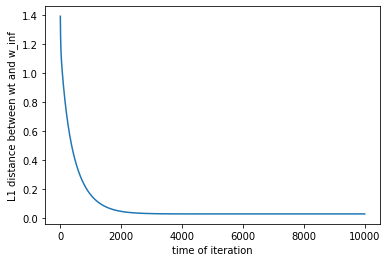

In [7]:
plt.plot(range(1,10001),distance[1:10001])
plt.xlabel('time of iteration')
plt.ylabel('L1 distance between wt and w_inf')

2

2(a)

In [8]:
class NMF:
    # initialize some paprameters
    def __init__(self, X, d=25, iters=100):
        self.X = X
        self.iterations = iters
        self.d = d
        self.W = np.random.uniform(1,2, size = (np.size(X, 0), d))  # N1 x D
        self.H = np.random.uniform(1,2, size = (d,np.size(X, 1)))  #  D x N2
        self.ones = np.ones((np.size(X, 0),np.size(X, 1)))
        
    def objective_calculate(self):
        # the objective function of the model
        objective = -np.sum(self.X*np.log(self.W.dot(self.H)+10**(-16))-self.W.dot(self.H))
        return objective
                            
    def train(self, train_data=None):
        train_objective_list = []
        for it in range(self.iterations):
            self.H = self.H*(self.W.T.dot(self.X/(self.W.dot(self.H)+10**(-16)))/(self.W.T.dot(self.ones)))
            self.W = self.W*((self.X/(self.W.dot(self.H)+10**(-16))).dot(self.H.T))/(self.ones.dot(self.H.T))
            
            # training evaluation
            train_objective = self.objective_calculate()
            train_objective_list.append(train_objective)

        return self.H, self.W, train_objective_list

In [9]:
X=np.zeros((3012,8447))
with open('hw4-data/nyt_data.txt') as fp:
    line = fp.readline()
    file = 0
    while line:
        for pair in line.split(','):
            (key,value) = pair.split(':')
            X[int(key)-1,file] = value 
        line = fp.readline()
        file += 1

In [10]:
model = NMF(X)

In [11]:
index = model.train()

Text(0, 0.5, 'objective function')

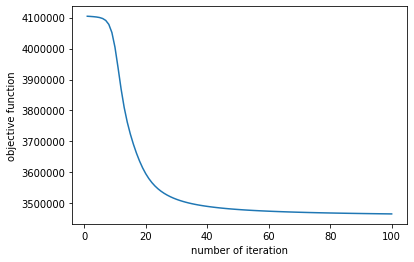

In [12]:
plt.plot(range(1,101),index[2][0:100])
plt.xlabel('number of iteration')
plt.ylabel('objective function')

(b)

In [13]:
W = index[1]
W_NORM = normalize(W, axis=0, norm='l1')
voc = pd.read_table('hw4-data/nyt_vocab.dat',header=None)
W_NORM = pd.DataFrame(W_NORM)
W_NORM.columns=W_NORM.columns.map(lambda x : 'Group ' + str(x))
W_NORM.insert(0,'Word', voc)

In [14]:
list_dfs = []
for i in range(25):
    temp = W_NORM.sort_values(by=W_NORM.columns[i+1], ascending=False).iloc[:,[0,i+1]].head(10)
    list_dfs.append(temp)
multi_column_df_display(list_dfs,5)

,Word,Group 0
226,worker,0.012316
7,city,0.011465
4,official,0.011086
86,cost,0.010192
39,pay,0.010020
155,car,0.009918
8,plan,0.009627
278,union,0.009346
2,state,0.009163
78,service,0.008786
